In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [3]:
# Load cleaned data
data = pd.read_csv('clean_train.csv', sep=';', decimal=',')

In [4]:
data.columns

Index(['TIMESTAMP', 'WEBSITE', 'GDS', 'DEPARTURE', 'ARRIVAL', 'ADULTS',
       'CHILDREN', 'INFANTS', 'TRAIN', 'HAUL_TYPE', 'DISTANCE', 'DEVICE',
       'TRIP_TYPE', 'PRODUCT', 'SMS', 'EXTRA_BAGGAGE', 'NO_GDS'],
      dtype='object')

In [25]:
# 'WEBSITE', 'DEVICE', 'HAUL_TYPE', 'TRIP_TYPE' and 'PRODUCT' 
numeric_columns = ['TIMESTAMP', 'GDS', 'DEPARTURE', 'ARRIVAL', 'ADULTS',
                   'CHILDREN', 'INFANTS', 'HAUL_TYPE', 'DISTANCE','NO_GDS']
data[numeric_columns].describe()

,TIMESTAMP,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,HAUL_TYPE,NO_GDS
count,49867.0,49867.000000,49867.000000,49867.000000,49867.000000,49867.000000,49867.000000,49867.000000,49867.000000
mean,26.0,0.641466,30.332585,31.012634,1.488640,0.098322,0.017647,0.744200,0.592917
std,0.0,0.582309,5.382638,6.061706,0.828472,0.388153,0.133481,0.844566,0.642457
min,26.0,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,26.0,0.000000,27.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,26.0,1.000000,29.000000,30.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,26.0,1.000000,32.000000,34.000000,2.000000,0.000000,0.000000,2.000000,1.000000
max,26.0,4.000000,52.000000,52.000000,9.000000,5.000000,2.000000,2.000000,4.000000


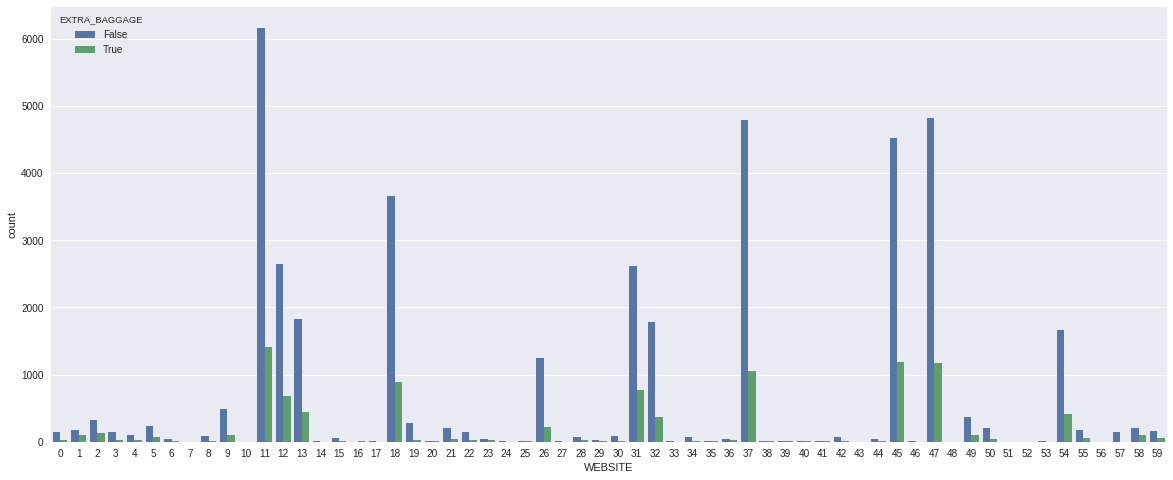

In [26]:
sns.countplot(x="WEBSITE", hue="EXTRA_BAGGAGE", data=data)

plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

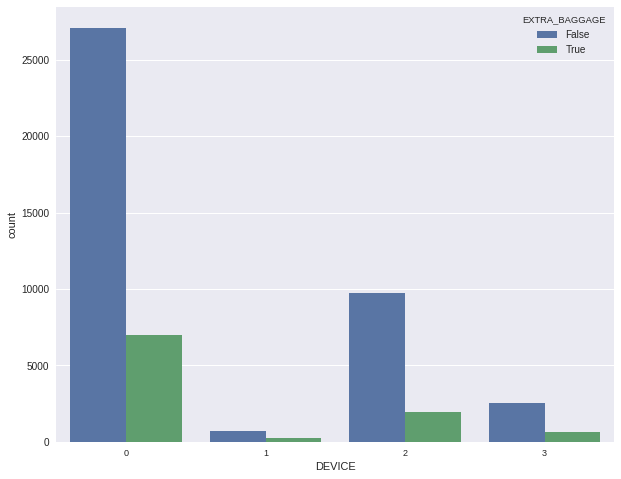

In [29]:
sns.countplot(x="DEVICE", hue="EXTRA_BAGGAGE", data=data)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 7

plt.show()

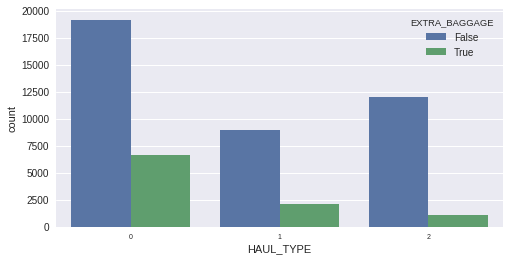

In [30]:
sns.countplot(x="HAUL_TYPE", hue="EXTRA_BAGGAGE", data=data)

plt.show()

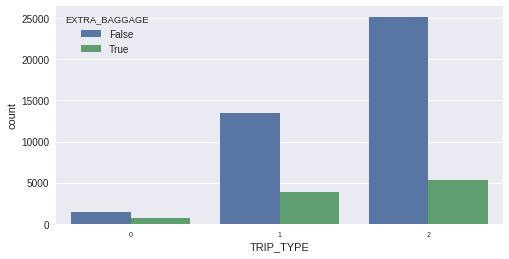

In [31]:
sns.countplot(x="TRIP_TYPE", hue="EXTRA_BAGGAGE", data=data)

plt.show()

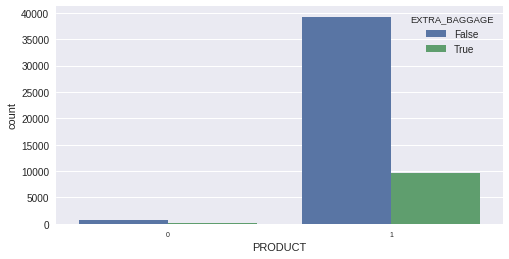

In [32]:
sns.countplot(x="PRODUCT", hue="EXTRA_BAGGAGE", data=data)

plt.show()

In [5]:
# Load original data
original_data = pd.read_csv('train.csv', sep=';', decimal=',')

In [23]:
# We'll enrich the dataset with new variables that may contribute to increase the model's
# performance.

# We'll add a variable called 'TRIP_DAYS' that will be created using the 'DEPARTURE' and 
# 'ARRIVAL' variables. It will represent the duration in days of the trip.
def calculate_trip_days(row):
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < departure_date.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    trip_days = arrival_date - departure_date
    
    return trip_days.days

trip_days = original_data.apply(lambda row: calculate_trip_days(row), axis=1)

data['TRIP_DAYS'] = trip_days[pd.notnull(original_data['DEVICE'])]

In [24]:
# We'll add a variable called 'PLANNING_DAYS' that will be created using the 'TIMESTAMP' and 
# 'DEPARTURE' variables. It will represent how many days ahead of the departure date, the trip
# was planned, starting from the day the plain tickets were bought.
def calculate_planning_days(row):
    buy_date = datetime.strptime(row['TIMESTAMP'] + "/2017", '%d/%B/%Y')
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    
    if departure_date.month < buy_date.month:
        departure_date = datetime.strptime(row['DEPARTURE'] + "/2018", '%d/%B/%Y')
    
    planning_days = departure_date - buy_date
    
    return planning_days.days

planning_days = original_data.apply(lambda row: calculate_planning_days(row), axis=1)

data['PLANNING_DAYS'] = planning_days[pd.notnull(original_data['DEVICE'])]

In [25]:
# We'll add a variable called 'WEEKEND_DAYS' that will be created using the 'DEPARTURE' and 
# 'ARRIVAL' variables. It will represent how many wekkend days are included in the duration
# of the trip.
def calculate_weekend_days(row):
    aux = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < aux.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    weekend_days = 0
    
    while (aux <= arrival_date):
        if (aux.weekday() > 4):
            weekend_days += 1
            
        aux = aux + timedelta(days=1)
    
    return weekend_days

weekend_days = original_data.apply(lambda row: calculate_weekend_days(row), axis=1)

data['WEEKEND_DAYS'] = weekend_days[pd.notnull(original_data['DEVICE'])]

In [29]:
# Store 'new_vars' dataset into new .csv file
data.to_csv('new_vars_train.csv', index=False, sep=';')

In [5]:
def plot_correlation_heatmap(data):
    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.show()

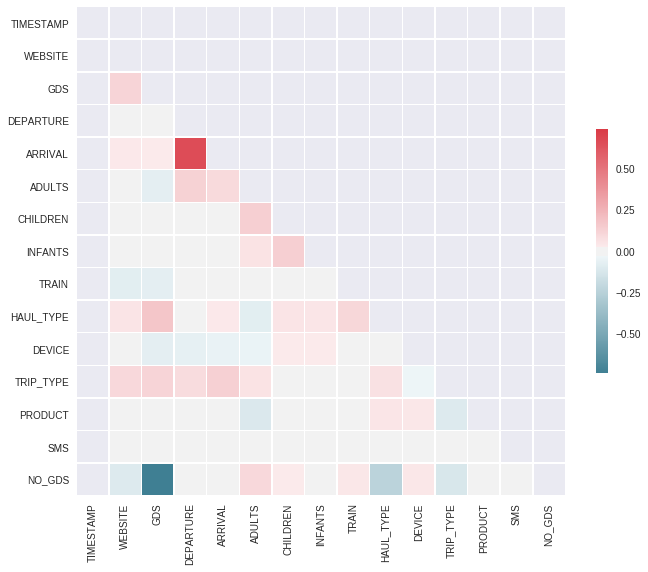

In [6]:
plot_correlation_heatmap(data.drop('EXTRA_BAGGAGE', 1))